# This project was created using Google Colab and the first 4 cells I am connecting to my google drive to get the dataset and extracting the files.

In [1]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
dl_file = drive.CreateFile({'id': '1Hks9_E8xm6OFY118iIjsiKrq63YiFfAX'})
dl_file.GetContentFile('dataset.tar')

In [5]:
import PIL
import os
import numpy as np
import keras
from keras.applications.vgg16 import decode_predictions
from keras import regularizers
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### After import all the libraries required in this project, I use the functions below to plot some graphs, load images and prepare the images to be used with the model.

In [0]:
#Function to get directory and file names
def path_join(dirname, filenames):
  return [os.path.join(dirname,filename) for filename in filenames]

#Function to load images
def load_images(image_paths):
  images = [plt.imread(path) for path in image_paths]
  return np.asarray(images)

#Function to plot model loss and acc
def plot_history(history):
  acc = history.history['categorical_accuracy']
  loss = history.history['loss']
  
  val_acc = history.history['val_categorical_accuracy']
  val_loss = history.history['val_loss']
  
  plt.plot(acc,color='b',label='Training Accuracy')
  plt.plot(loss,color='g',label='Training Loss')
  plt.plot(val_acc,color='r',label='Test Accuracy')
  plt.plot(val_loss,color='y',label='Test Loss')
  plt.title('Training and Test Accuracy and Loss')
  plt.legend()
  plt.rcParams['figure.figsize'] = (17,7)
  plt.show()
  
#Function to reshape images and predict withe the model
def predict(image_path):
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape,PIL.Image.LANCZOS)
    
    plt.imshow(img_resized)
    plt.show()
    
    img_array = np.expand_dims(np.array(img_resized),axis=0)
    
    pred = model_vgg.predict(img_array)
    
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%}: {1}".format(score,name))
  
#Function to plot images from directory
def plot_image(img, figsize=(12,6), rows=1, interp=False, titles=None):
  if type(img[0]) is np.ndarray:
    img = np.array(img).astype(np.uint8)
    if (img.shape[-1] != 3):
      img = img.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = len(img)//rows if len(img)%2 == 0 else len(img)//rows+1
  for i in range(len(img)):
    sp = f.add_subplot(rows,cols,i+1)
    sp.axis('Off')
    if title is not None:
      sp.set_title(titles[i], fontsize=12)
    plt.imshow(img[i],interpolation=None if interp else 'none')
    
    
#Function to create confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix without normalization')
  
  print(cm)
  
  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

### Below I import the VGG16 model which after fine tunning it will classify images in two classes (animals and insects).

In [0]:
model_vgg = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')

In [8]:
input_shape = model_vgg.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [0]:
#Transformation for images

imggen_train = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 rescale=1./255,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')
imggen_test = ImageDataGenerator(rescale=1./255)

In [48]:
batch_size = 10

generator_train = imggen_train.flow_from_directory(directory='Dataset/Train/',
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=True)
generator_test = imggen_test.flow_from_directory(directory='Dataset/Test/',
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

Found 307 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [22]:
#Number of steps for data generator
steps_test = generator_test.n/batch_size
steps_test

15.4

In [0]:
train_dir = 'Dataset/Train'
test_dir = 'Dataset/Test'

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Below I use an image from my dataset and we can see that the model successfully classified the animal in this image. However I will modify the VGG model because I don't need five classes and the percentage.

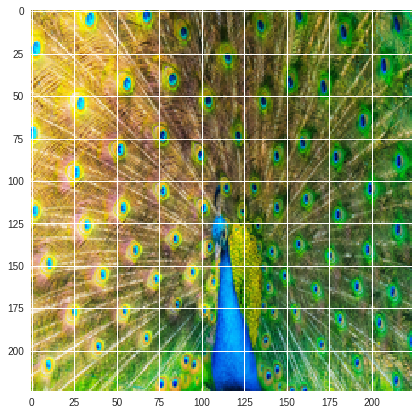

99.13%: peacock
 0.27%: umbrella
 0.15%: lorikeet
 0.09%: sarong
 0.06%: lacewing


In [51]:
predict(image_path=image_paths_train[50])

In [52]:
model_vgg.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
#Keep all the conv blocks

#Set reference for the block to keras
transfer_layer = model_vgg.get_layer('block5_pool')

In [0]:
#Creating a new model with the input and conv blocks from the vgg model
conv_model = Model(inputs=model_vgg.input,
                  outputs=transfer_layer.output)

In [0]:
#Build last connected layers to the model

new_model = Sequential()

new_model.add(conv_model)

new_model.add(Flatten())

new_model.add(Dense(500,activation='relu'))

new_model.add(Dropout(0.5))

new_model.add(Dense(2,activation='softmax'))

In [67]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1002      
Total params: 27,260,190
Trainable params: 12,545,502
Non-trainable params: 14,714,688
_________________________________________________________________


### At this first try I set the layers from the VGG model to not be trainable.

In [0]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [0]:
new_model.compile(Adam(lr=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_categorical_accuracy',patience=5)
callbacks_list = [earlystop]

In [71]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=80,
                                  steps_per_epoch=100,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                  callbacks=callbacks_list)

Epoch 1/80
100/100 [==============================] - 37s 369ms/step - loss: 0.5771 - categorical_accuracy: 0.7183 - val_loss: 0.2390 - val_categorical_accuracy: 0.9091
Epoch 2/80
100/100 [==============================] - 36s 362ms/step - loss: 0.3320 - categorical_accuracy: 0.8651 - val_loss: 0.1995 - val_categorical_accuracy: 0.8961
Epoch 3/80
100/100 [==============================] - 36s 362ms/step - loss: 0.2628 - categorical_accuracy: 0.8844 - val_loss: 0.1718 - val_categorical_accuracy: 0.9091
Epoch 4/80
100/100 [==============================] - 36s 364ms/step - loss: 0.2264 - categorical_accuracy: 0.9181 - val_loss: 0.1538 - val_categorical_accuracy: 0.9221
Epoch 5/80
100/100 [==============================] - 37s 369ms/step - loss: 0.2087 - categorical_accuracy: 0.9039 - val_loss: 0.1521 - val_categorical_accuracy: 0.9221
Epoch 6/80
100/100 [==============================] - 36s 359ms/step - loss: 0.1926 - categorical_accuracy: 0.9180 - val_loss: 0.1393 - val_categorical_acc

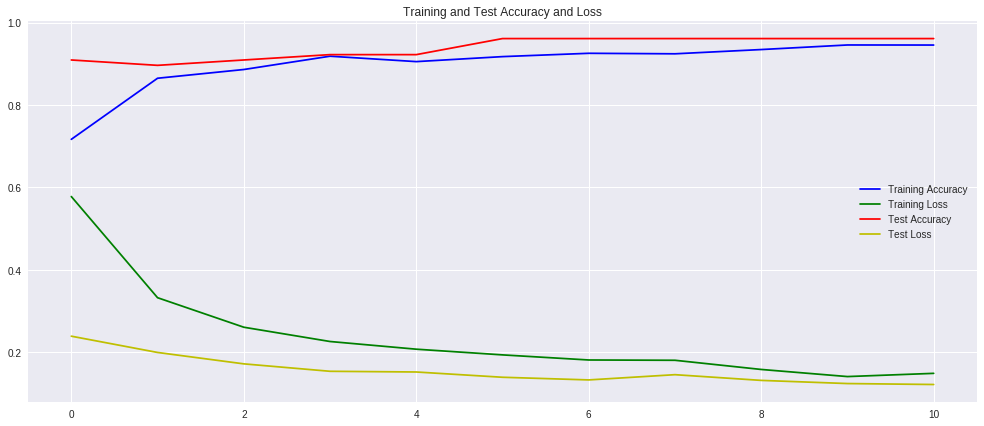

In [72]:
plot_history(history)

### The model reach an accuracy of 96%. What if we train some layers from VGG model?
### Can this accuracy be higher?

In [11]:
batch_size = 5

generator_train = imggen_train.flow_from_directory(directory='Dataset/Train/',
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=True)
generator_test = imggen_test.flow_from_directory(directory='Dataset/Test/',
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

Found 307 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [0]:
#Fine tuning to see if the acc improves
conv_model.trainable = True

for layer in conv_model.layers:
    trainable = ('block5' in layer.name)
    
    layer.trainable = trainable

In [0]:
#Build last connected layers to the model

new_model2 = Sequential()

new_model2.add(conv_model)

new_model2.add(Flatten())

new_model2.add(Dense(130,activation='relu'))

new_model2.add(Dropout(0.5))

new_model2.add(Dense(2,activation='softmax'))

In [17]:
new_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               3261570   
_________________________________________________________________
dropout_1 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 262       
Total params: 17,976,520
Trainable params: 10,341,256
Non-trainable params: 7,635,264
_________________________________________________________________


In [162]:
'''
#Fine tuning to see if the acc improves
conv_model.trainable = True

for layer in conv_model.layers:
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    layer.trainable = trainable
'''

"\n#Fine tuning to see if the acc improves\nconv_model.trainable = True\n\nfor layer in conv_model.layers:\n    trainable = ('block5' in layer.name or 'block4' in layer.name)\n    \n    layer.trainable = trainable\n"

In [0]:
new_model2.compile(Adam(lr=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_categorical_accuracy',patience=3)
callbacks_list = [earlystop]

In [27]:
history2 = new_model2.fit_generator(generator=generator_train,
                                  epochs=80,
                                  steps_per_epoch=100,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)
                                  #callbacks=callbacks_list)

Epoch 1/80
100/100 [==============================] - 21s 211ms/step - loss: 0.5117 - categorical_accuracy: 0.7300 - val_loss: 0.2471 - val_categorical_accuracy: 0.8961
Epoch 2/80
100/100 [==============================] - 20s 204ms/step - loss: 0.3382 - categorical_accuracy: 0.8680 - val_loss: 0.1801 - val_categorical_accuracy: 0.9481
Epoch 3/80
100/100 [==============================] - 20s 203ms/step - loss: 0.2367 - categorical_accuracy: 0.8950 - val_loss: 0.1411 - val_categorical_accuracy: 0.9481
Epoch 4/80
100/100 [==============================] - 21s 207ms/step - loss: 0.2019 - categorical_accuracy: 0.9170 - val_loss: 0.1960 - val_categorical_accuracy: 0.9481
Epoch 5/80
100/100 [==============================] - 20s 199ms/step - loss: 0.1865 - categorical_accuracy: 0.9260 - val_loss: 0.1040 - val_categorical_accuracy: 0.9610
Epoch 6/80
100/100 [==============================] - 20s 204ms/step - loss: 0.1301 - categorical_accuracy: 0.9520 - val_loss: 0.0995 - val_categorical_acc

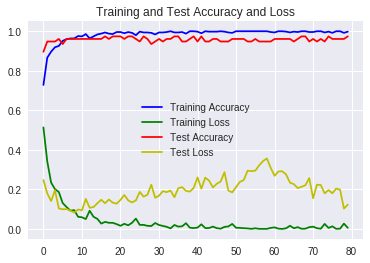

In [28]:
plot_history(history2)

In [0]:
generator_test.reset()
result = new_model2.evaluate_generator(generator_test, steps=steps_test)

In [31]:
class_names = list(generator_train.class_indices.keys())
class_names

['Animals', 'Insects']

In [32]:
print("test-set classification accuracy: {0:.2%}".format(result[1]))

test-set classification accuracy: 97.40%


In [0]:
#Function to reshape the images to predict with model

def predict_nmodel(image_path):
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape,PIL.Image.LANCZOS)
    
    plt.imshow(img_resized)
    plt.show()
    
    img_array = np.expand_dims(np.array(img_resized),axis=0)
    
    pred = new_model2.predict(img_array)
    pred = pred[:,0]
    if pred[0] == 1.0:
      print("Animal")
    else:
      print("Insect")
    

### I used some images provided by my coleagues who work with insects to see the classification.

In [34]:
from io import BytesIO
from google.colab import files

uploaded = files.upload()


Saving sap8.jpg to sap8.jpg


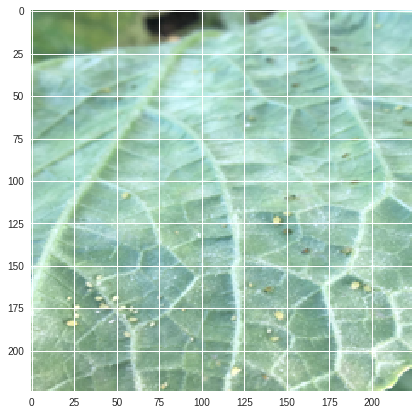

Insect


In [37]:
predict_nmodel(image_path='sap8.jpg')

In [112]:
from io import BytesIO
from google.colab import files

uploaded = files.upload()
image2 = uploaded

Saving sap7.jpg to sap7.jpg


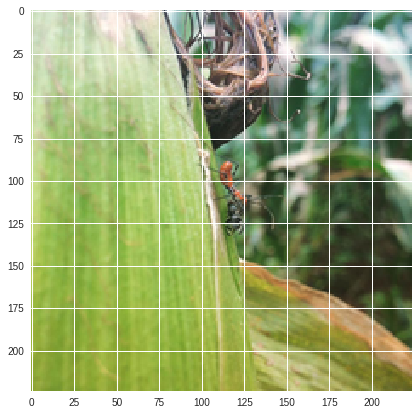

Insect


In [38]:
predict_nmodel('sap7.jpg')

### Then I saved the model and uploaded to my Google Drive.

In [39]:
# serialize model to JSON
model_json = new_model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
new_model2.save_weights("model_weights.h5")
print("Model saved")

Model saved


In [43]:
#Save model and weights in google drive


# Which file to send?
file_name = "model_weights.h5"

from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {'name': name, 'mimeType': 'application/octet-stream'}
  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)
  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
  
  return created

save_file_to_drive(file_name, file_name)

{'id': '11GfxhfLJyj9WWgEparwwtiRNRZq3fkfA'}